# Distracted Driving Detection

## Load the Data

In [1]:
#dictionary for distraction category to numerical value
catLabels = {
    'c0': 'safe driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': 'texting - left',
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup', 
    'c9': 'talking to passenger'
}

def getClass(value):
    index = 'c' + str(value)
    return catLabels[index]


In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import os
from sklearn.model_selection import train_test_split

import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

# import tensorflow as tf
# from keras import backend as K

# num_cores = 4
# GPU = 1
# CPU = 0

# if GPU:
#     num_GPU = 1
#     num_CPU = 1
# if CPU:
#     num_CPU = 1
#     num_GPU = 0

# config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
#         inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
#         device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
# session = tf.Session(config=config)
# K.set_session(session)

def loadImages(path):
        data = load_files(path)
        files = data['filenames']
        targets = data['target']
        target_names = data['target_names']
        return files, targets, target_names

path = "images/train"
files,targets,target_names = loadImages(path)
predict_files = np.array(glob("images/test/*"))[1:10]
print('Number of Categories: ', len(target_names))
print('Categories: ', target_names)
print('Number of images by category: ')
for c in target_names:
    print(c + ':' + str(len( os.listdir(path+'/'+c))))
    # train_data = np.vstack((files, targets)).T
    # print(train_data.shape)

#Split the original training sets into training & validation sets
train_files, test_files, train_targets, test_targets = train_test_split(files, targets, test_size=0.20, random_state=40)

print(train_files.shape, test_files.shape, train_targets.shape, test_targets.shape)
print(len(test_files))


Using TensorFlow backend.


b'Hello, TensorFlow!'
Number of Categories:  10
Categories:  ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
Number of images by category: 
c0:1900
c1:1900
c2:1900
c3:1900
c4:1900
c5:1900
c6:1900
c7:1900
c8:1900
c9:1900
(15200,) (3800,) (15200,) (3800,)
3800


# Data Analysis

8
hair and makeup


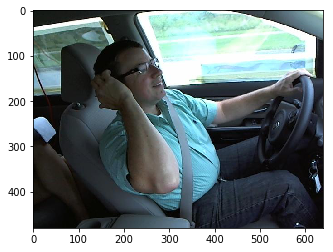

9
talking to passenger


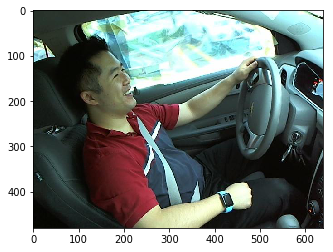

0
safe driving


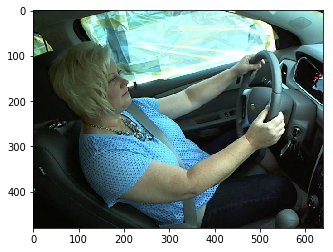

0
safe driving


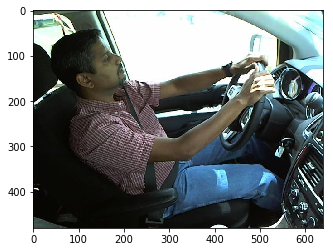

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def displayImage(sample_image):
    gray = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
    
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

for i in range(1,5):
    sample_image = cv2.imread(train_files[i])
    print(train_targets[i])
    print(getClass(train_targets[i]))
    displayImage(sample_image)
    


In [4]:

#(nb_samples,rows,columns,channels)
#nb_samples - total number of images
# Resize image to 224x224 
# Convert image to an array -> resized to a 4D tensor used by Keras CNN
# Tensor will be (1,224,224,3)

#Adopted from the Deep Learning Project
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    print (img_paths)
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


## Pre-Process the Data


In [5]:
#Rescale the images 

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

train_tensors = paths_to_tensor(train_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255
#predict_tensors = paths_to_tensor(predict_files).astype('float32')/255


['images/train\\c3\\img_24663.jpg' 'images/train\\c8\\img_98810.jpg'
 'images/train\\c9\\img_67390.jpg' ..., 'images/train\\c7\\img_31727.jpg'
 'images/train\\c7\\img_82756.jpg' 'images/train\\c5\\img_21995.jpg']


100%|███████████████████████████████████████████████████████████████████████████| 15200/15200 [01:21<00:00, 186.64it/s]


['images/train\\c5\\img_68264.jpg' 'images/train\\c6\\img_69335.jpg'
 'images/train\\c2\\img_12280.jpg' ..., 'images/train\\c8\\img_6916.jpg'
 'images/train\\c6\\img_21610.jpg' 'images/train\\c5\\img_46343.jpg']


100%|█████████████████████████████████████████████████████████████████████████████| 3800/3800 [00:25<00:00, 151.51it/s]


## Baseline Model Architecture

In [56]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ActivityRegularization
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils import plot_model
from keras import regularizers
import sys
        
def create_base_model():
    model = Sequential()
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=10, activation='softmax'))
    print("Base Model")
    model.summary()
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return {"model": model, "model_name": sys._getframe().f_code.co_name}

def create_model1():
    model = Sequential()
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=10, activation='softmax'))
    print("Model1 with Batch Normalization")
    model.summary()
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return {"model": model, "model_name": sys._getframe().f_code.co_name}

def create_model2():
    model = Sequential()
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=10, activation='softmax'))
    print("Model2 - Multiple conv2d layers")
    model.summary()
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return {"model": model, "model_name": sys._getframe().f_code.co_name}

def create_model3():
    model = Sequential()
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=10, activation='softmax'))
    print("Model3 - Multiple conv2d layers w/ Batch Normalization for each Conv2D")
    model.summary()
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return {"model": model, "model_name": sys._getframe().f_code.co_name}

def create_model4():
    model = Sequential()
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=10, activation='softmax'))
    model.add(Dense(units=10, activation='softmax'))
    print("Model4 - Multiple conv2d layers w/ Batch Normalization for each Conv2D + 2 softmax layers")
    model.summary()
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return {"model": model, "model_name": sys._getframe().f_code.co_name}

def create_model5():
    model = Sequential()
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(.1))
    model.add(Dense(units=10, activation='softmax'))
    model.add(Dropout(.2))
    model.add(Dense(units=10, activation='softmax'))
    model.add(Dropout(.3))
    model.add(Dense(units=10, activation='softmax'))
    print("Model5 - Multiple conv2d layers w/ Batch Normalization for each Conv2D + 3 softmax layers + Dropouts")
    model.summary()
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return {"model": model, "model_name": sys._getframe().f_code.co_name}

def create_model6():
    model = Sequential()
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(Dropout(.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(Dropout(.15))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(Conv2D(filters=10, kernel_size=(4,4), input_shape=(224,224,3)))
    model.add(Dropout(.20))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(.1))
    model.add(Dense(units=10, activation='softmax'))
    model.add(Dropout(.2))
    model.add(Dense(units=10, activation='softmax'))
    model.add(Dropout(.3))
    model.add(Dense(units=10, activation='softmax'))
    print("Model6 - Dropouts + Multiple conv2d layers w/ Batch Normalization for each Conv2D + 3 softmax layers + Dropouts")
    model.summary()
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return {"model": model, "model_name": sys._getframe().f_code.co_name}

models = [create_base_model(), create_model1(), create_model2(), create_model3(),
          create_model4(), create_model5(), create_model6() ]

for m in models:
    print (m)
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))


Base Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 221, 221, 10)      490       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 55, 55, 10)        0         
_________________________________________________________________
global_average_pooling2d_47  (None, 10)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 10)                110       
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________
Model1 with Batch Normalization
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 221, 221, 10)      490       
___________________________________

dense_84 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_53 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 10)                110       
Total params: 4,160
Trainable params: 4,100
Non-trainable params: 60
_________________________________________________________________
Model6 - Dropouts + Multiple conv2d layers w/ Batch Normalization for each Conv2D + 3 softmax layers + Dropouts
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 221, 221, 10)      490       
_________________________________________________________________
dropout_54 (Dropout)         (None, 221, 221, 10)      0         
_________________________________________________________________
batch_normalization_75 (Bat

## Train the Model

In [61]:
from keras.callbacks import ModelCheckpoint  
from keras.utils import np_utils
import datetime, random, pickle

print("Train Targets", train_targets)
print ("Test Targets", test_targets)
train_targets_onehot = np_utils.to_categorical(np.array(train_targets),10)
test_targets_onehot = np_utils.to_categorical(np.array(test_targets),10)
print ("Train Targets One-hot encoded", train_targets_onehot)
print ("Test Targets One-hot encoded", test_targets_onehot)

print(train_targets_onehot.shape)
print(test_targets_onehot.shape)

file_root='C:/Users/pushkar/ML/machine-learning/projects/capstone/saved_models/'
prefix_str = str(datetime.date.today()) + str(random.randint(1,100))
NUM_EPOCHS = 200

def train_model(_epochs, _model):
    history = _model.fit(train_tensors, train_targets_onehot, validation_split=.20,
          epochs=_epochs, batch_size=32, callbacks=[checkpointer], verbose=2)
    return history

for m in models:
    print ("Training Model: ", m['model_name'])
    prefix_str = m['model_name'] + str(datetime.date.today()) + str(random.randint(1,100))
    checkpointer = ModelCheckpoint(filepath=file_root + prefix_str + '_model.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
    m['history'] = train_model(NUM_EPOCHS,m['model'])
    with open(file_root + prefix_str + '_trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

        

Train Targets [3 8 9 ..., 7 7 5]
Test Targets [5 6 2 ..., 8 6 5]
Train Targets One-hot encoded [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Test Targets One-hot encoded [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(15200, 10)
(3800, 10)
Training Model:  create_base_model
Train on 12160 samples, validate on 3040 samples
Epoch 1/1
 - 65s - loss: 2.3027 - acc: 0.1023 - val_loss: 2.3039 - val_acc: 0.1164

Epoch 00001: val_loss improved from inf to 2.30389, saving model to C:/Users/pushkar/ML/machine-learning/projects/capstone/saved_models/create_base_model2018-03-1376_model.best.from_scratch.hdf5
Training Model:  create_model1
Train on 12160 samples, validate on 3040 samples
Epoch 1/1


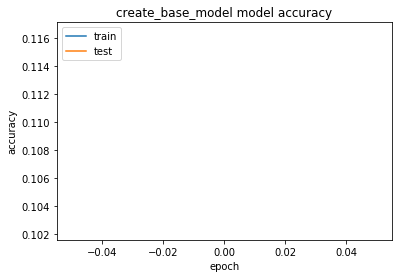

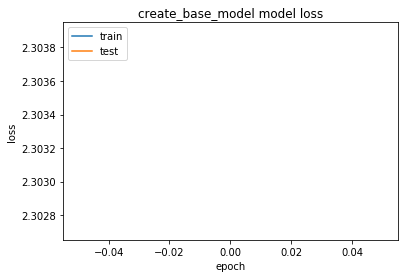

Model: create_base_model
Test accuracy: 64.0263%


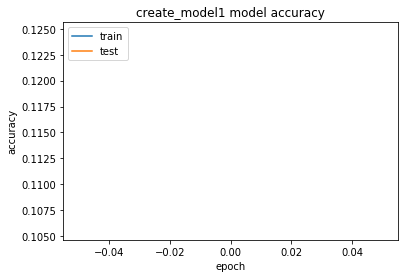

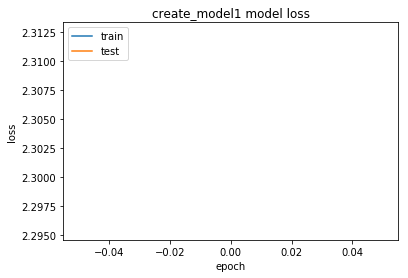

Model: create_model1
Test accuracy: 0.0000%


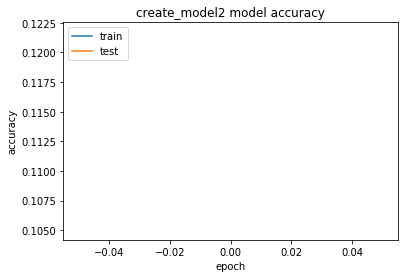

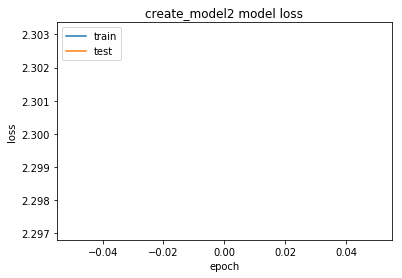

Model: create_model2
Test accuracy: 7.1842%


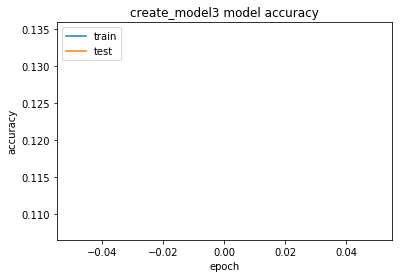

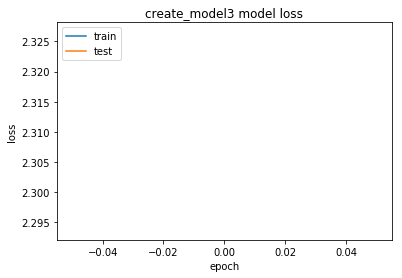

Model: create_model3
Test accuracy: 0.0000%


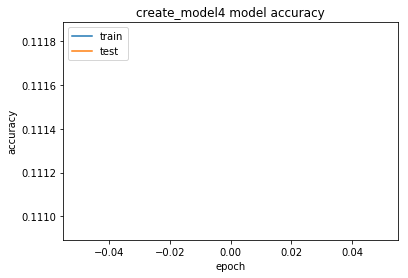

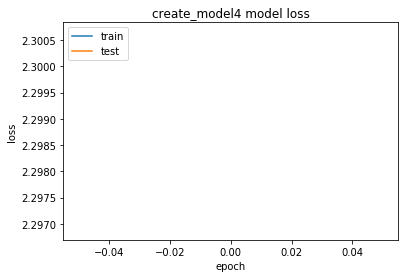

Model: create_model4
Test accuracy: 0.0000%


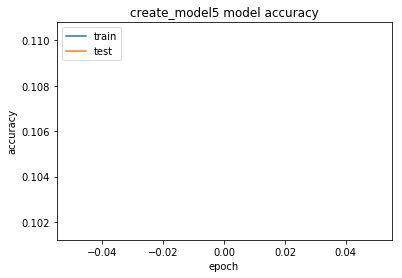

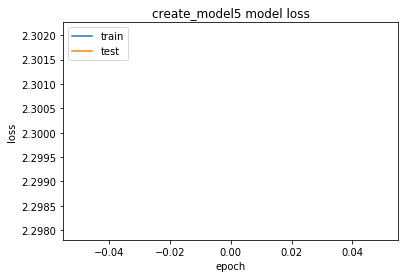

Model: create_model5
Test accuracy: 0.0000%


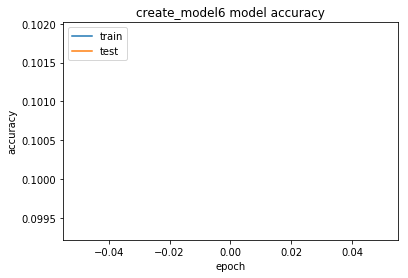

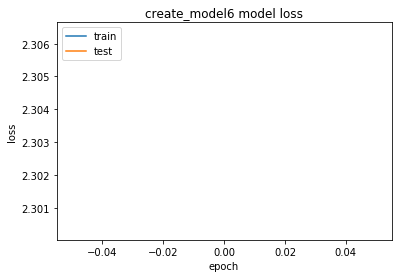

Model: create_model6
Test accuracy: 0.0000%


In [69]:
import matplotlib.pyplot as plt
import numpy as py

def predict_distraction(model):
    # get index of predicted distraction for each image in test set
    distraction_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(distraction_predictions)==np.argmax(test_targets, axis=0))/len(distraction_predictions)
    return test_accuracy


for m in models:
    history = m['history']
    # history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(m['model_name'] + ' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    prefix_str = m['model_name'] + str(datetime.date.today()) + str(random.randint(1,100))

    plt.imsave(fname=file_root + prefix_str + '_model_accuracy.png', format="png", arr = [history.history['acc'], history.history['val_acc']])

    #  history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(m['model_name'] + ' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.imsave(fname=file_root + prefix_str + '_model_loss.png', format="png", arr = [history.history['loss'], history.history['val_loss']])

    print("Model: " + m['model_name'])
    test_accuracy = predict_distraction(m['model'])
    print('Test accuracy: %.4f%%' % test_accuracy)


#    p = m.predict(test_tensors)
#print (p)
#z=np.argmax(p,axis=1)
#print("z = ", z)
# for i in range(1,15):
#     img = np.squeeze(np.array(test_tensors[i]))
#     displayImage(img)
#     print("Predicted class", getClass(z[i]))
#     print ("Actual Class", getClass(test_targets[i]))

                               